# Overview of Data Science Life Cycle

source: https://www.textbook.ds100.org/ch/01/lifecycle_intro.html

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import interact, interactive, fixed, interact_manual

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


sns.set()

## An example on Student Names

Key learning points:
- pivot table
- groupby().apply(func) where func applies to a group. Could be defined using universal functions.
- Series.apply(func) applies to a single series.

In [9]:
students = pd.read_csv('https://raw.githubusercontent.com/DS-100/fa19/master/lecture/lec01/roster.csv')
students

,Name,Role
0,Hanyu,Student
1,Sarah,Waitlist Student
2,Xingyu,Student
3,Jingxi,Student
4,Vyom,Student
...,...,...
1120,Yuner,Waitlist Student
1121,Darren,Waitlist Student
1122,Kai,Waitlist Student
1123,Shunhua,Waitlist Student


In [11]:
# Removing the last row.
students['Name'] = students['Name'].str.lower()
# students = students.drop([1124], axis=0) # Run Once
students

,Name,Role
0,hanyu,Student
1,sarah,Waitlist Student
2,xingyu,Student
3,jingxi,Student
4,vyom,Student
...,...,...
1119,chloe,Waitlist Student
1120,yuner,Waitlist Student
1121,darren,Waitlist Student
1122,kai,Waitlist Student


In [13]:
## Counting roles
students["Role"].value_counts().to_frame()

,Role
Student,824
Waitlist Student,300


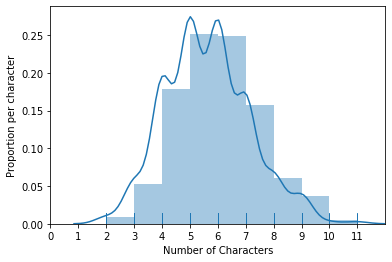

In [26]:
## Summarizing Names
sns.distplot(students['Name'].str.len(),
            rug=True,
            bins=np.arange(12),
            axlabel="Number of Characters")
plt.xlim(0,12)
plt.xticks(np.arange(12))
plt.ylabel('Proportion per character');

### 1. Are names predictive of sex?

We begin by plotting the number of male and female births over the years.

In [27]:
import urllib.request
import os.path

data_url = "https://www.ssa.gov/oact/babynames/names.zip"
local_filename = "babynames.zip"
if not os.path.exists(local_filename): # if the data exists don't download again
    with urllib.request.urlopen(data_url) as resp, open(local_filename, 'wb') as f:
        f.write(resp.read())
        
import zipfile
babynames = [] 
with zipfile.ZipFile(local_filename, "r") as zf:
    data_files = [f for f in zf.filelist if f.filename[-3:] == "txt"]
    def extract_year_from_filename(fn):
        return int(fn[3:7])
    for f in data_files:
        year = extract_year_from_filename(f.filename)
        with zf.open(f) as fp:
            df = pd.read_csv(fp, names=["Name", "Sex", "Count"])
            df["Year"] = year
            babynames.append(df)
babynames = pd.concat(babynames)
babynames

,Name,Sex,Count,Year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880
...,...,...,...,...
32028,Zylas,M,5,2018
32029,Zyran,M,5,2018
32030,Zyrie,M,5,2018
32031,Zyron,M,5,2018


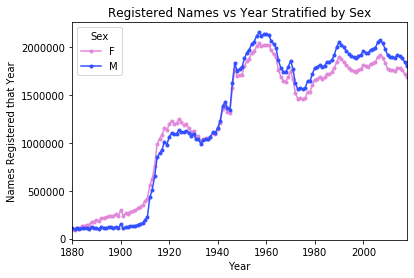

In [31]:
# Show the sum of male and female births across different names over each year. 
# In a pivot table, we need both index and columns are faceting variables, values is the item aggregating over.
pivot_year_name_count = pd.pivot_table(
    babynames, index='Year', columns='Sex',
    values='Count', aggfunc=np.sum)

pivot_year_name_count

pink_blue = ["#E188DB", "#334FFF"]
with sns.color_palette(sns.color_palette(pink_blue)):
    pivot_year_name_count.plot(marker=".")
    plt.title("Registered Names vs Year Stratified by Sex")
    plt.ylabel('Names Registered that Year')

Sex ratio among new-borns seems to vary within a range ove the years.

Next we build a predictor of sex based on name, and check its accuracy over our sample.

In [32]:
babynames['Name'] = babynames['Name'].str.lower()
babynames

,Name,Sex,Count,Year
0,mary,F,7065,1880
1,anna,F,2604,1880
2,emma,F,2003,1880
3,elizabeth,F,1939,1880
4,minnie,F,1746,1880
...,...,...,...,...
32028,zylas,M,5,2018
32029,zyran,M,5,2018
32030,zyrie,M,5,2018
32031,zyron,M,5,2018


In [44]:
sex_counts = pd.pivot_table(babynames, 
              index = "Name",
              columns = "Sex",
              values = "Count",
              aggfunc=np.sum, margins=True)
sex_counts = sex_counts.fillna(0)
prop_female = sex_counts["F"]/sex_counts["All"]
sex_counts["prop_female"] = prop_female
sex_counts


Sex,F,M,All,prop_female
Name,,,,
aaban,0.0,114.0,114,0.000000
aabha,35.0,0.0,35,1.000000
aabid,0.0,16.0,16,0.000000
aabidah,5.0,0.0,5,1.000000
aabir,0.0,10.0,10,0.000000
...,...,...,...,...
zyvon,0.0,7.0,7,0.000000
zyyanna,6.0,0.0,6,1.000000
zyyon,0.0,6.0,6,0.000000


In [45]:
def sex_from_name(name):
    if name in sex_counts.index:
        prop = sex_counts.loc[name, 'prop_female']
        return 'F' if prop > 0.5 else 'M'
    else:
        return 'Name not in dataset'

sex_from_name('sam')

'M'

In [49]:
students['sex'] = students['Name'].apply(sex_from_name)
students
students["sex"].value_counts().to_frame()

,sex
M,548
F,404
Name not in dataset,172


### 2. Inferring age from name

In [53]:
## Define a function applied to a group.
def avg_year(group):
    return np.average(group['Year'], weights=group['Count'])
## Notice how the func in apply is applied to a group, not a single entry.
avg_years = (
    babynames
    .groupby('Name')
    .apply(avg_year)
    .rename('avg_year')
    .to_frame()
)
avg_years

,avg_year
Name,
aaban,2013.333333
aabha,2013.714286
aabid,2012.687500
aabidah,2018.000000
aabir,2017.000000
...,...
zyvion,2009.000000
zyvon,2015.000000
zyyanna,2010.000000


In [60]:
def year_from_name(name):
    return (avg_years.loc[name, 'avg_year']
            if name in avg_years.index
            else None)

students['year'] = students['Name'].apply(year_from_name)
students

,Name,Role,sex,year
0,hanyu,Student,Name not in dataset,NaN
1,sarah,Waitlist Student,F,1974.706350
2,xingyu,Student,Name not in dataset,NaN
3,jingxi,Student,Name not in dataset,NaN
4,vyom,Student,M,2012.945736
...,...,...,...,...
1119,chloe,Waitlist Student,F,2004.646359
1120,yuner,Waitlist Student,Name not in dataset,NaN
1121,darren,Waitlist Student,M,1979.313235
1122,kai,Waitlist Student,M,2007.637293


In [64]:
interact(year_from_name, name='shiyang');

interactive(children=(Text(value='fernando', description='name'), Output()), _dom_classes=('widget-interact',)…

35.510604860585545

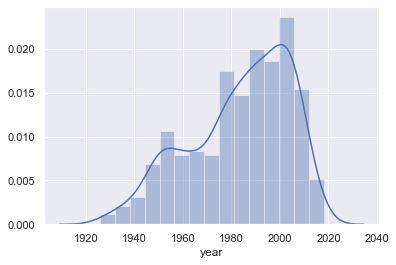

In [70]:
sns.distplot(students['year'].dropna());
2019 - students['year'].mean()

According to our predictive model, the average age in class is 35, which obviously contradicts our expectation. An explanation could be that common names are used over the years. Let's see what names are most popular in this class:

In [88]:
students.groupby("Name").size().to_frame(name="count").sort_values("count", ascending=False).head(20)

,count
Name,
kevin,13
eric,12
ryan,12
daniel,10
jessica,9
david,8
catherine,7
john,7
nicholas,6


Ok. John seems pretty popular. We plots its usage over the years, and indeed the usage is spread about.

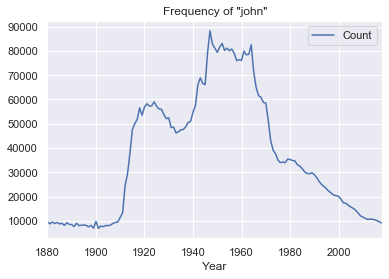

In [72]:
names = babynames.set_index('Name').sort_values('Year')
john = names.loc['john']
john[john['Sex'] == 'M'].plot('Year', 'Count')
plt.title('Frequency of "john"');

But the name Kayne is used in a more concentrated manner.

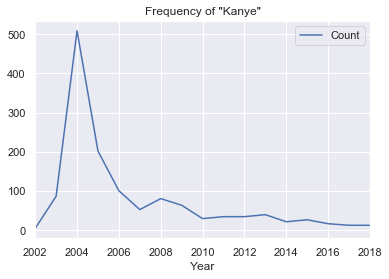

In [71]:
names = babynames.set_index('Name').sort_values('Year')
kanye = names.loc['kanye']
kanye[kanye['Sex'] == 'M'].plot('Year', 'Count')
plt.title('Frequency of "Kanye"');

In [23]:
# Quick calculation of total payment from an amortizing loan
term = 36
r = 0.1465 / 12
installment = 327.7
principle = 9500
df = pd.DataFrame({
    "principle_beginning": np.zeros(term),
    "interest": np.zeros(term),
    "interest_payment": np.zeros(term),
    "principle_payment": np.zeros(term),
    "principle_afterPayment": np.zeros(term)
})
df["interest"] = r
df.ix[0, "principle_beginning"] = principle
df.ix[0, "interest_payment"] = df.ix[0, "principle_beginning"] * r
df.ix[0, "principle_payment"] = installment - df.ix[0, "interest_payment"]
df.ix[0, "principle_afterPayment"] = df.ix[0, "principle_beginning"] - df.ix[0, "principle_payment"]

for i in range(1,term):
    df.ix[i,"principle_beginning"] = df.ix[i-1, "principle_afterPayment"]
    df.ix[i, "interest_payment"] = df.ix[i, "principle_beginning"] * r
    df.ix[i, "principle_payment"] = installment - df.ix[i, "interest_payment"]
    df.ix[i, "principle_afterPayment"] = df.ix[i, "principle_beginning"] - df.ix[i, "principle_payment"]
    
df

C:\Users\nleea\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
C:\Users\nleea\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app
C:\Users\nleea\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()
C:\Users\nleea\Anaconda3\

,principle_beginning,interest,interest_payment,principle_payment,principle_afterPayment
0,9500.000000,0.012208,115.979167,211.720833,9288.279167
1,9288.279167,0.012208,113.394408,214.305592,9073.973575
2,9073.973575,0.012208,110.778094,216.921906,8857.051669
3,8857.051669,0.012208,108.129839,219.570161,8637.481508
4,8637.481508,0.012208,105.449253,222.250747,8415.230761
5,8415.230761,0.012208,102.735942,224.964058,8190.266704
6,8190.266704,0.012208,99.989506,227.710494,7962.556210
7,7962.556210,0.012208,97.209540,230.490460,7732.065750
8,7732.065750,0.012208,94.395636,233.304364,7498.761386
9,7498.761386,0.012208,91.547379,236.152621,7262.608765


In [29]:
np.sum(df['principle_payment']) + np.sum(df['interest_payment'])
term * installment
total_payment = 9616.54
term / (total_payment/installment) * 30

11797.2

11797.199999999999

36.80284177053285